In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
print(len(data))

9093


# remove missing data

In [14]:
# remove all rows with any missing value
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
data = data_no_missing
# data = data_no_missing.reset_index()
print(len(data))

6584


In [13]:
# remove all data or year for countries where one of the 3 variables is entirely missing

country_temp_data = {}
country_precip_data = {}

for row in data.iterrows():
    country = row[1].iso
    if country not in country_temp_data:
        country_temp_data[country] = []
    if country not in country_precip_data:
        country_precip_data[country] = []
    country_temp_data[country].append(row[1].UDel_temp_popweight)
    country_precip_data[country].append(row[1].UDel_precip_popweight)

countries_missing_temp = [country for country in country_temp_data if all(np.isnan(country_temp_data[country]))]
countries_missing_precip = [country for country in country_precip_data if all(np.isnan(country_precip_data[country]))]

countries_to_remove = set(countries_missing_temp + countries_missing_precip)

print(countries_to_remove)

indices_to_drop = []
for index, row in enumerate(data.itertuples()):
    if row.iso in countries_to_remove:
        indices_to_drop.append(index)

data_len_before = len(data)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(f"Removed {data_len_before - len(data)} rows for completely missing country data.")

{'SGP', 'SMR', 'MHL', 'MAC', 'KNA', 'BMU', 'LCA', 'MDV', 'TON', 'BHR', 'GRD', 'SYC', 'MCO', 'PLW', 'ATG', 'HKG', 'BRB', 'FSM', 'ADO', 'ABW', 'MNE', 'TMP', 'TUV', 'MLT', 'KIR', 'LIE', 'CHI', 'WBG', 'KSV', 'IMY', 'COD', 'DMA', 'TWN', 'ROU'}
Removed 1262 rows for completely missing country data.


# data scaling

In [12]:
precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# linear regression

In [8]:
from sklearn.linear_model import LinearRegression
y = np.array(data.growthWDI).reshape(-1,1)
x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight),data.UDel_precip_popweight,np.square(data.UDel_precip_popweight)]))
# x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]] [0.01702781]


In [103]:
from sklearn.linear_model import LinearRegression
y = np.array(gdp_scaled).reshape(-1,1)
# x = np.transpose(np.array([temp_scaled,np.square(temp_scaled),precip_scaled,np.square(precip_scaled)]))
x = np.transpose(np.array([temp_scaled,np.square(temp_scaled)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[-0.09037139 -0.03925769]] [0.03925769]


In [106]:
print((model.coef_[0][0] * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - 2 * (model.coef_[0][1] * np.mean(data.UDel_temp_popweight) * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight))))
print(model.coef_[0][1] * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
# print(.0953 * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight))
# print(.1543 * np.std(data.growthWDI) / np.square(np.std(data.UDel_precip_popweight)))

0.0008977706911867145
-4.343603854139065e-05


# year and country fixed effect coefficient matrices

In [13]:
min_year = min(data.year)
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - min_year
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1
country_mult_mat[0] = [1 for i in range(len(data))]

In [14]:
# gradual year-by-year effects
grad_effects_data1 = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_yi'))]))#/1000
grad_effects_data2 = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y2'))]))#/1000000
grad_effects_data = np.concatenate([grad_effects_data1, grad_effects_data2])

In [1]:
with pm.Model() as model:

    gdp_intercept = pm.Normal("gdp_intercept", 0,5)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,1)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,1)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,1)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,1)

    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data.iso))-1)),axis=1)
    country_coefs = pm.math.concatenate([[[0]],country_coefs])
    country_fixed_effects = pt.sum((country_mult_mat*country_coefs),axis=0)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data.year))-1)),axis=1)
    year_coefs = pm.math.concatenate([[[0]],year_coefs])
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 5, shape=(len(grad_effects_data))),axis=1)
    gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))

    gdp_prior = pm.Deterministic(  
        "gdp_prior",
        gdp_intercept +
        (temp_gdp_coef * temp_scaled) +
        (temp_sq_gdp_coef * pt.sqr(temp_scaled)) +
        (precip_gdp_coef * precip_scaled) +
        (precip_sq_gdp_coef * pt.sqr(precip_scaled)) +
        country_fixed_effects +
        year_fixed_effects +
        gradual_effects
    )

    # standard error clustered by country
    country_std = pt.expand_dims(pm.HalfNormal("country_std", sigma=1, shape=(len(set(data.iso)),)),axis=1)
    gdp_std = pm.Deterministic("gdp_std", pt.sum(country_std * country_mult_mat,axis=0))
    # gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)
    
    # prior = pm.sample_prior_predictive()
    # trace = pm.sample(target_accept=.99)
    # posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

NameError: name 'pm' is not defined

In [8]:
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

In [43]:
az.summary(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
temp_gdp_coef,-0.640,0.221,-1.061,-0.225,0.016,0.011,191.0,491.0,1.02
temp_sq_gdp_coef,-0.454,0.090,-0.623,-0.284,0.004,0.003,606.0,1520.0,1.01
precip_gdp_coef,0.053,0.063,-0.066,0.172,0.002,0.001,1501.0,2235.0,1.00
precip_sq_gdp_coef,-0.042,0.022,-0.083,-0.001,0.000,0.000,1931.0,2377.0,1.00
gdp_intercept,0.386,0.423,-0.412,1.210,0.050,0.038,71.0,128.0,1.06


/tmp/ipykernel_5773/3226979871.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


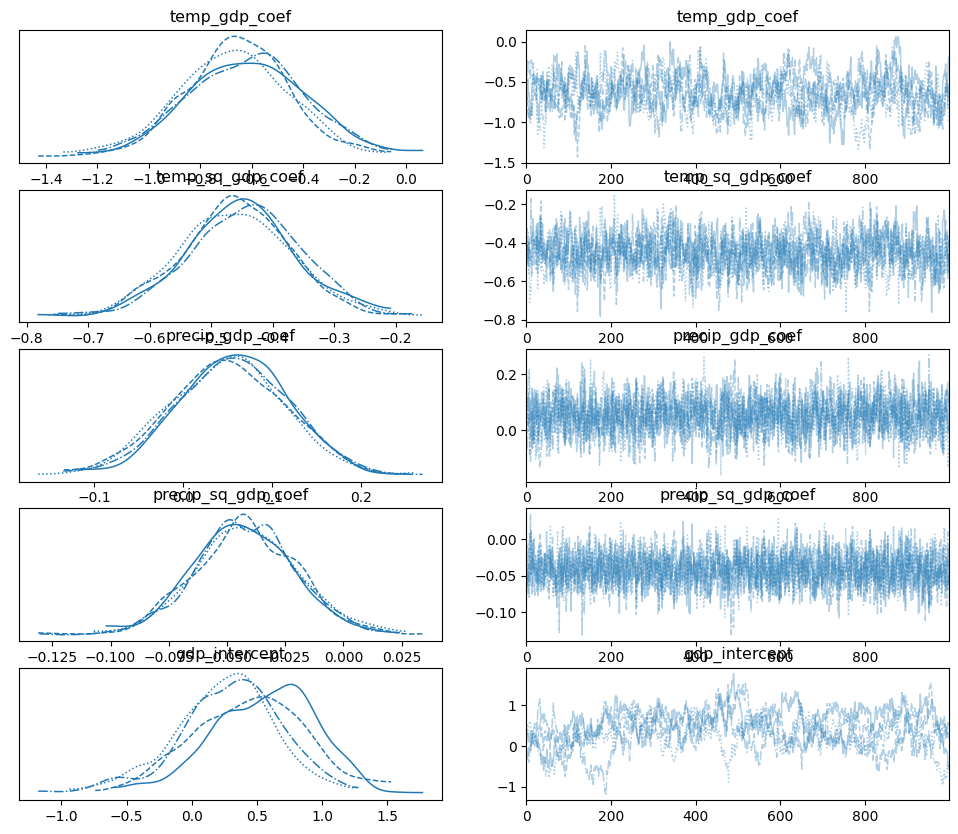

In [44]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef", "gdp_intercept"]).ravel()[0].figure
fig.show()

# Bayesian model Uncertainty Bounds

In [15]:
random.seed(1)
indices = random.sample(range(4000),1000)
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef1 = (coef1 * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * (coef2 * np.mean(data.UDel_temp_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
coef2 = (coef2 * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
coef1 = [sample for index, sample in enumerate(coef1) if index in indices]
coef2 = [sample for index, sample in enumerate(coef2) if index in indices]
numerator = [val for val in coef1]
denominator = [-2*(val) for val in coef2]
bayes_res = np.array(numerator) / np.array(denominator)
bayes_interval = np.quantile(sorted(bayes_res),[.05,.95])
print(np.mean(bayes_res), bayes_interval[0], bayes_interval[1])

13.667917470588941 10.941736577560095 16.305551240529617


# Homespun Bootstrap Uncertainty Bounds

In [13]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_better_column_names.csv", header=1)[:1000]
numerator = [val for val in bootstrap_reps["temp"] if not np.isnan(val)]
denominator = [-2*(val) for val in bootstrap_reps["c.temp#c.temp"] if not np.isnan(val)]
boot_res = np.array(numerator) / np.array(denominator)
boot_interval = np.quantile(boot_res,[.05,.95])
print(np.mean(boot_res), boot_interval[0], boot_interval[1])

13.35981574323662 10.17496944932989 17.224900438584346


# Make histogram figure

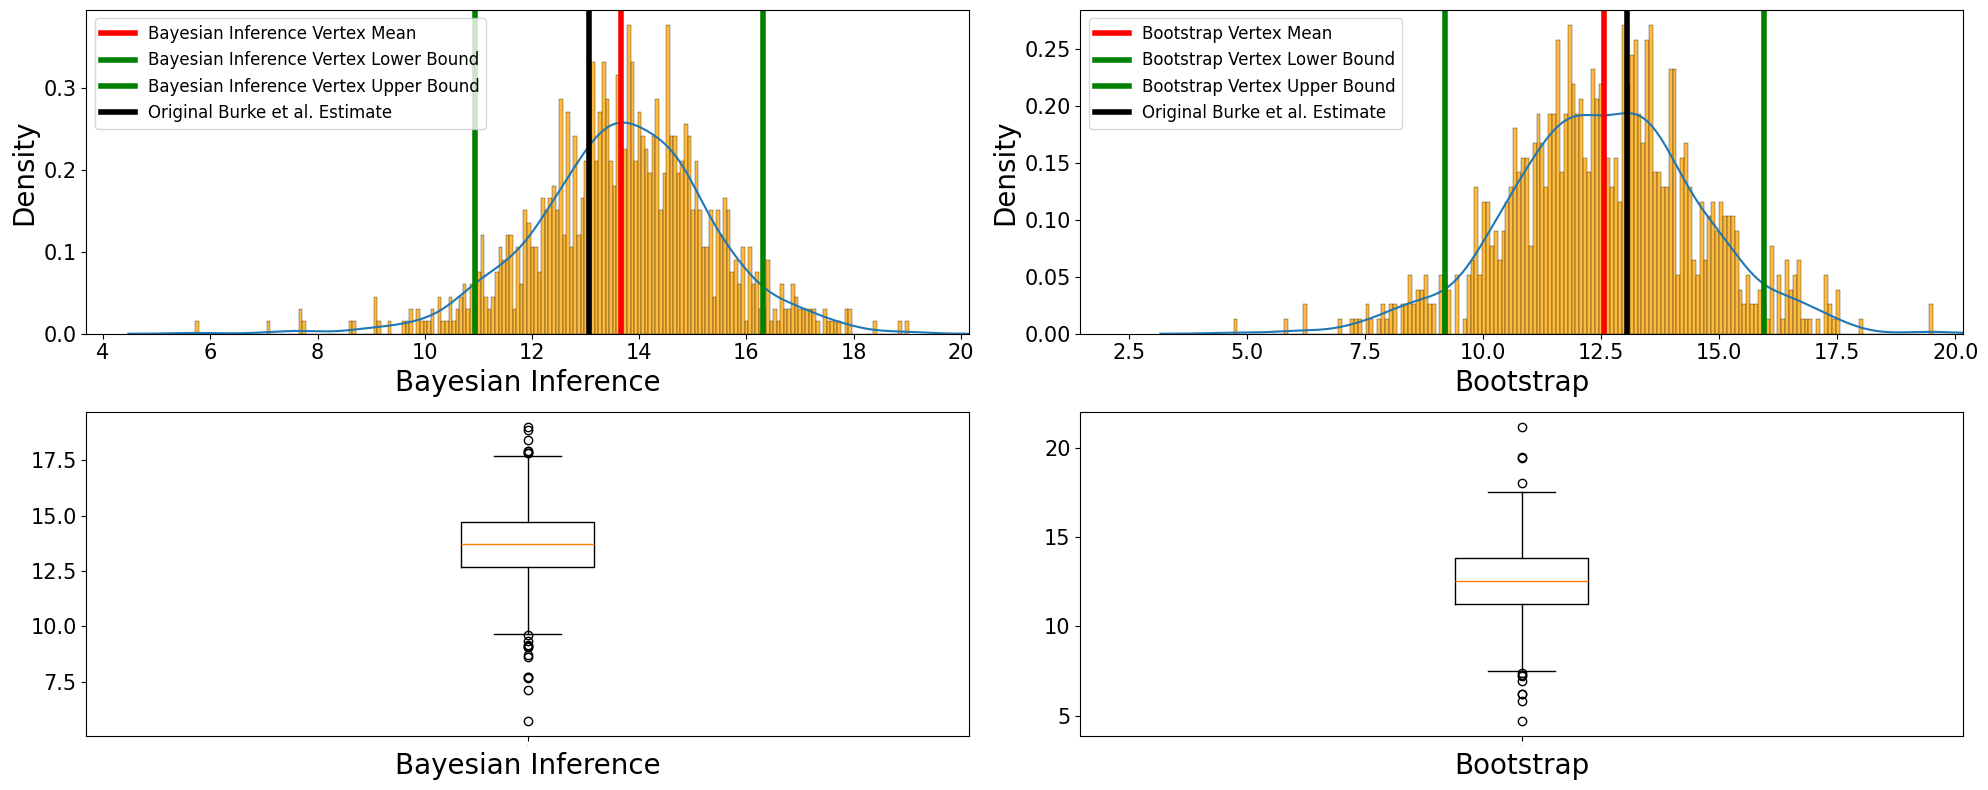

In [21]:
fig, axes = plt.subplots(2,2, figsize=(20,8))

x = np.linspace(np.mean(bayes_res) - 3*np.std(bayes_res), np.mean(bayes_res) + 3*np.std(bayes_res), 100)
sns.histplot(bayes_res,bins=200,color="orange",stat="density", ax=axes[0][0])
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(bayes_res, ax=axes[0][0])
axes[0][0].axvline(x = np.mean(bayes_res), color = 'r', lw = 4, label = 'Bayesian Inference Vertex Mean')
axes[0][0].axvline(x = bayes_interval[0], color = 'g', lw = 4, label = 'Bayesian Inference Vertex Lower Bound')
axes[0][0].axvline(x = bayes_interval[1], color = 'g', lw = 4, label = 'Bayesian Inference Vertex Upper Bound')
axes[0][0].axvline(x = 13.055431, color = 'k', lw = 4, label = 'Original Burke et al. Estimate')
axes[0][0].set_xlim(min(x)-5, max(x)+1.5)
axes[0][0].set_xlabel("Bayesian Inference")
axes[0][0].xaxis.label.set_size(20)
axes[0][0].yaxis.label.set_size(20)
axes[0][0].legend(fontsize=12)
axes[0][0].xaxis.set_tick_params(labelsize=15)
axes[0][0].yaxis.set_tick_params(labelsize=15)

x = np.linspace(np.mean(boot_res) - 3*np.std(boot_res), np.mean(boot_res) + 3*np.std(boot_res), 100)
sns.histplot(boot_res,bins=200,color="orange",stat="density", ax=axes[0][1])
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(boot_res, ax=axes[0][1])
axes[0][1].axvline(x = np.mean(boot_res), color = 'r', lw = 4, label = 'Bootstrap Vertex Mean')
axes[0][1].axvline(x = boot_interval[0], color = 'g', lw = 4, label = 'Bootstrap Vertex Lower Bound')
axes[0][1].axvline(x = boot_interval[1], color = 'g', lw = 4, label = 'Bootstrap Vertex Upper Bound')
axes[0][1].axvline(x = 13.055431, color = 'k', lw = 4, label = 'Original Burke et al. Estimate')
axes[0][1].set_xlim(min(x)-5, max(x)+1.5)
axes[0][1].set_xlabel("Bootstrap")
axes[0][1].xaxis.label.set_size(20)
axes[0][1].yaxis.label.set_size(20)
axes[0][1].legend(fontsize=12)
axes[0][1].xaxis.set_tick_params(labelsize=15)
axes[0][1].yaxis.set_tick_params(labelsize=15)

axes[1][0].boxplot(bayes_res)
axes[1][0].set_xlabel("Bayesian Inference")
axes[1][0].xaxis.label.set_size(20)
axes[1][0].xaxis.set_tick_params(labelsize=.0001)
axes[1][0].yaxis.set_tick_params(labelsize=15)

axes[1][1].boxplot(boot_res)
axes[1][1].set_xlabel("Bootstrap")
axes[1][1].xaxis.label.set_size(20)
axes[1][1].xaxis.set_tick_params(labelsize=.0001)
axes[1][1].yaxis.set_tick_params(labelsize=15)

fig.tight_layout()
plt.savefig("../figures/burke_histograms.png", bbox_inches='tight')

# Estimate affected countries based on CMIP6

In [50]:
temp_projections = pd.read_csv(
    "../data/global_data/cmip6-x0.25_timeseries_tas_timeseries-tas-annual-mean_annual_2015-2100_median_ssp119_ensemble_all_mean - all.csv"
)
mean_point_estimate = np.mean([np.mean(bayes_res),np.mean(boot_res),13.055431])
mean_lower_estimate = np.mean([bayes_interval[0],boot_interval[0],10.208829])
mean_upper_estimate = np.mean([bayes_interval[1],boot_interval[1],15.902034])
mean_countries = set()
range_countries = set()
count = 0
for row in temp_projections.iterrows():
    row = row[1]
    country = row.code
    if "." not in country:
        temp_2015 = row["2024-07"]
        temp_2100 = row["2100-07"]
        if temp_2015 < mean_point_estimate and temp_2100 > mean_point_estimate:
            mean_countries.add(country)
        if temp_2100 > mean_lower_estimate and temp_2100 < mean_upper_estimate:
            range_countries.add(country)
print(sorted(list(cc.convert(names = mean_countries, to = 'name_short'))))
print(sorted(list(cc.convert(names = range_countries, to = 'name_short'))))

KSV not found in ISO3


['Croatia', 'Japan', 'Nepal']
['Afghanistan', 'Albania', 'Argentina', 'Azerbaijan', 'Belgium', 'Bhutan', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'France', 'Germany', 'Greece', 'Guernsey', 'Hungary', 'Ireland', 'Isle of Man', 'Italy', 'Japan', 'Jersey', 'Lesotho', 'Moldova', 'Monaco', 'Montenegro', 'Nepal', 'Netherlands', 'New Zealand', 'North Macedonia', 'Romania', 'San Marino', 'Serbia', 'Slovenia', 'South Korea', 'Spain', 'Türkiye', 'United States', 'Uzbekistan', 'not found']
